#### Projected subgradient method

We extend subgradient to solve constrained convex optimization

$$\min f(x), \, \text{s.t. }x\in C$$

The `projected` subgradient step is given by

$$x^{k+1}=P(x^k-\alpha_kg^k)$$

##### Convergence analysis

Let $z^{k+1}=x^k-\alpha_kg^k$, then following analysis of subgradient method, we have

$$\begin{align*}
\|z^{k+1}-x^*\|_2^2 &\leq \|x^k-x^*\|_2^2 -2\alpha_k \left(f(x^k)-f^*\right) +\alpha_k^2\|g^k\|_2^2 \\
\end{align*}$$

Since when we project a point onto $C$, we move closer to every point in $C$, including $x^*$, therefore

$$\|x^{k+1}-x^*\|_2=\|P(z^{k+1})-x^*\|_2\leq \|z^{k+1}-x^*\|_2$$

Combine these two, we have

$$\begin{align*}
\|x^{k+1}-x^*\|_2^2 &\leq \|x^k-x^*\|_2^2 -2\alpha_k \left(f(x^k)-f^*\right) +\alpha_k^2\|g^k\|_2^2 \\
\end{align*}$$

and the rest follows exactly the subgradient method

#### Linear equality constraints

When the constrains is affine, we can more explicitly write out the projected subgradient step

$$\min f(x),\, \text{s.t. }Ax=b$$

Assuming $A$ is fat and full rank, projection of $z$ onto $\{x|Ax=b\}$ can be obtained by solving

$$\arg \min_x \frac{1}{2}\|x-z\|_2^2, \text{s.t. }Ax=b$$

We write out the Lagragian

$$L(x, \lambda)=\frac{1}{2}\|x-z\|_2^2+\lambda^T(Ax-b)$$

Solve this using stationary condition

$$\frac{\partial L}{\partial x}=x-z+A^T\lambda=0 \Longrightarrow x=z-A^T\lambda$$

Plug into $Ax=b$, we have

$$A(z-A^T\lambda)=Az-AA^T\lambda=b$$

Solve for $\lambda$ ($(AA^T)^{-1}$ is invertible due to $A$ being fat and full rank)

$$\lambda = (AA^T)^{-1}(Az-b)$$

Plug back to $x=z-A^T\lambda$, we get the projection

$$\begin{align*}
P(z)=x&=z-A^T(AA^T)^{-1}(Az-b)\\
&=(I-A^T(AA^T)^{-1}A)z+A^T(AA^T)^{-1}b
\end{align*}$$

We see that $A^T(AA^T)^{-1}A$ is the projection matrix onto $R(A^T)$

(Recall if $A$ is tall and full rank, projection matrix onto $R(A)$ is $A(A^TA)^{-1}A^T$)

$P(z)$ consists of two parts
* one ensures $x$ lies in null space (orthogonal complement of $R(A^T)$) of $A$
* another satisfies $Ax=b$

With the projection function, we can write the projected subgradient step

First, since $x^k$ is feasible, then

$$x^k=P(x^k)=(I-A^T(AA^T)^{-1}A)x^k+A(AA^T)^{-1}b$$

and

$$\begin{align*}
x^{k+1}&=P(x^k-\alpha_kg^k) \\
&=(I-A^T(AA^T)^{-1}A)(x^k-\alpha_kg^k)+A(AA^T)^{-1}b \\
&=(I-A^T(AA^T)^{-1}A)x^k+A(AA^T)^{-1}b-\alpha_k(I-A^T(AA^T)^{-1}A)g^k \\
&=x^k-\alpha_k(I-A^T(AA^T)^{-1}A)g^k
\end{align*}$$

##### 1-norm minimization

We can use the projected subgradient to solve constrained 1-norm minimization

$$\min \|x\|_1,\, \text{s.t. } Ax=b$$

where $g^k=\text{sgn}(x^k)$

In [19]:
import numpy as np
import matplotlib.pyplot as plt
import cvxpy as cp
import time
np.set_printoptions(formatter={'float': '{: 0.4f}'.format})

plt.style.use('dark_background')
# color: https://matplotlib.org/stable/gallery/color/named_colors.htm

In [20]:
def subgrad_constrained_l1(A, x1, a=0.1, tol=1e-3, n_iter=3000):
    # simple l1 minimization with linear equality constraint

    f = [np.inf]
    f_best = [np.inf]
    x = x1.copy()
    proj_na = np.eye(x.shape[0]) - A.T @ np.linalg.inv(A @ A.T) @ A

    for k in range(1, n_iter+1):
        subgrad = np.sign(x)
        f_val = np.linalg.norm(x, ord=1)

        # Step size
        alpha = a / k

        f.append(f_val)
        f_best.append(min(f_val, f_best[-1]))

        # Subgradient step
        x -= alpha * proj_na @ subgrad

    hist = {'f': f, 'f_best': f_best}

    return x, hist

In [21]:
np.random.seed(42)
n = 1000  # size of x
m = 500
A = np.random.randn(m, n)
b = np.random.randn(m)
x1 = np.linalg.pinv(A) @ b # least norm solution

# Get optimal value using CVXPY
x_var = cp.Variable(n)
objective = cp.Minimize(cp.norm(x_var, 1))
constraints = [A @ x_var == b]
problem = cp.Problem(objective, constraints)
problem.solve()
f_min = problem.value

optimal f (CVXPY): 20.9577
optimal f: 20.9720, 21.5143, 23.8816


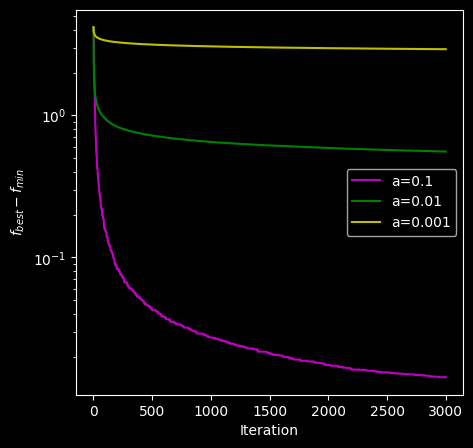

In [22]:
tol = 1e-3
n_iter = 3000
a = [1e-1, 1e-2, 1e-3]
iters = np.arange(1, n_iter + 1)

x1_hist, hist1 = subgrad_constrained_l1(A, x1, a[0], tol=tol, n_iter=n_iter)
x2_hist, hist2 = subgrad_constrained_l1(A, x1, a[1], tol=tol, n_iter=n_iter)
x3_hist, hist3 = subgrad_constrained_l1(A, x1, a[2], tol=tol, n_iter=n_iter)
print(f"optimal f (CVXPY): {f_min:.4f}")
print(f"optimal f: {hist1['f_best'][-1]:.4f}, {hist2['f_best'][-1]:.4f}, {hist3['f_best'][-1]:.4f}")

fig, ax = plt.subplots(figsize=(5, 5))

ax.semilogy(iters, np.array(hist1['f_best'][1:]) - f_min, 'm-', label=f'a={a[0]}')
ax.semilogy(iters, np.array(hist2['f_best'][1:]) - f_min, 'g-', label=f'a={a[1]}')
ax.semilogy(iters, np.array(hist3['f_best'][1:]) - f_min, 'y-', label=f'a={a[2]}')
ax.set_xlabel('Iteration')
ax.set_ylabel('$f_{best}-f_{min}$')
ax.legend()
plt.show()